In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import pickle
from tqdm import tqdm
import torch.nn.utils as nn_utils
import numpy as np

In [2]:
class RadialBasisFunction(nn.Module):
    def __init__(
            self,
            grid_min: float = -1.7,
            grid_max: float = 2.2,
            num_grids: int = 4,
            denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANConvNDLayer(nn.Module):
    def __init__(self, conv_class, norm_class, input_dim, output_dim, kernel_size,
                 groups=1, padding=0, stride=1, dilation=1,
                 ndim: int = 2, grid_size=4, base_activation=nn.SiLU, grid_range=[-1.7, 2.2], dropout=0.0, **norm_kwargs):
        super(FastKANConvNDLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.ndim = ndim
        self.grid_size = grid_size
        self.base_activation = base_activation()
        self.grid_range = grid_range
        self.norm_kwargs = norm_kwargs

        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if input_dim % groups != 0:
            raise ValueError('input_dim must be divisible by groups')
        if output_dim % groups != 0:
            raise ValueError('output_dim must be divisible by groups')

        self.base_conv = nn.ModuleList([conv_class(input_dim // groups,
                                                   output_dim // groups,
                                                   kernel_size,
                                                   stride,
                                                   padding,
                                                   dilation,
                                                   groups=1,
                                                   bias=True) for _ in range(groups)])

        self.spline_conv = nn.ModuleList([conv_class(grid_size * input_dim // groups,
                                                     output_dim // groups,
                                                     kernel_size,
                                                     stride,
                                                     padding,
                                                     dilation,
                                                     groups=1,
                                                     bias=True) for _ in range(groups)])

        self.layer_norm = nn.ModuleList([norm_class(input_dim // groups, **norm_kwargs) for _ in range(groups)])

        self.rbf = RadialBasisFunction(grid_range[0], grid_range[1], grid_size)

        self.dropout = None
        if dropout > 0:
            if ndim == 1:
                self.dropout = nn.Dropout1d(p=dropout)
            if ndim == 2:
                self.dropout = nn.Dropout2d(p=dropout)
            if ndim == 3:
                self.dropout = nn.Dropout3d(p=dropout)

        # Initialize weights using Kaiming uniform distribution for better training start
        for conv_layer in self.base_conv:
            nn.init.kaiming_uniform_(conv_layer.weight, nonlinearity='linear')

        for conv_layer in self.spline_conv:
            nn.init.kaiming_uniform_(conv_layer.weight, nonlinearity='linear')

    def forward_fast_kan(self, x, group_index):

        # Apply base activation to input and then linear transform with base weights
        base_output = self.base_conv[group_index](self.base_activation(x))
        if self.dropout is not None:
            x = self.dropout(x)
        spline_basis = self.rbf(self.layer_norm[group_index](x))
        spline_basis = spline_basis.moveaxis(-1, 2).flatten(1, 2)
        spline_output = self.spline_conv[group_index](spline_basis)
        x = base_output + spline_output

        return x

    def forward(self, x):
        split_x = torch.split(x, self.inputdim // self.groups, dim=1)
        output = []
        for group_ind, _x in enumerate(split_x):
            y = self.forward_fast_kan(_x, group_ind)
            output.append(y.clone())
        y = torch.cat(output, dim=1)
        return y


class FKConv(FastKANConvNDLayer):
    def __init__(self, input_dim, output_dim, kernel_size, groups=1, padding=0, stride=1, dilation=1,
                 grid_size=4, base_activation=nn.SiLU, grid_range=[-1.7, 2.2], dropout=0.0,
                 norm_layer=nn.InstanceNorm2d, **norm_kwargs):
        super(FKConv, self).__init__(nn.Conv2d, norm_layer,
                                                 input_dim, output_dim,
                                                 kernel_size,
                                                 groups=groups, padding=padding, stride=stride, dilation=dilation,
                                                 ndim=2,
                                                 grid_size=grid_size, base_activation=base_activation,
                                                 grid_range=grid_range,
                                                 dropout=dropout, **norm_kwargs)

In [3]:
# Building Blocks for the Diffusion Model

# Sinusoidal time embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.embedding_dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb 

# Diffusion Process and Sampling

def get_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

class Diffusion:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.beta = get_beta_schedule(timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    def add_noise(self, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

In [4]:
def sample(model, diffusion, shape, device, save_all=0):
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape, device=device)
        T = diffusion.timesteps
        for t in reversed(range(T)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            epsilon = model(x, t_tensor)
            alpha_t = diffusion.alpha[t]
            alpha_bar_t = diffusion.alpha_bar[t]
            beta_t = diffusion.beta[t]
            alpha_bar_prev = diffusion.alpha_bar[t-1] if t > 0 else torch.tensor(1.0, device=device)
            sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))
            mean = 1 / torch.sqrt(alpha_t) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon)
            noise = torch.randn_like(x) if t > 0 else 0
            x = mean + sigma_t * noise
            if save_all:
                save_all_timestep_images(x, T-t)
        return x

#Save all timestep images
def save_all_timestep_images(x, num):
    try:
        os.makedirs("timestep_images")
    except FileExistsError:
        pass

    grid2 = make_grid(torch.clamp(denormalize(x.clone().cpu()), 0.0, 1.0), nrow=4)
    
    save_image(grid2, f"/kaggle/working/timestep_images/{num}.png")

In [5]:
# Function to denormalize the images
def denormalize(tensor, 
                mean=torch.tensor([0.5062, 0.4256, 0.3830]).view(3, 1, 1), 
                std=torch.tensor([0.3035, 0.2831, 0.2826]).view(3, 1, 1)
               ):
    return tensor * std + mean

In [6]:
# Save model
def save_model(model, epoch):
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), f"diffusion_model_kanc_attention_epoch_{epoch}.pth")
    else:
        torch.save(model.state_dict(), f"diffusion_model_kanc_attention_epoch_{epoch}.pth")
    print("Model saved.")

# Save losses as a pickle file
def save_data(all_losses,last_batch_loss_per_epoch,avg_loss_per_epoch,epoch):
    
    with open(f'all_losses_{epoch}.pkl', 'wb') as f:
        pickle.dump(all_losses, f)
    
    with open(f'last_batch_loss_per_epoch_{epoch}.pkl', 'wb') as f:
        pickle.dump(last_batch_loss_per_epoch, f)
    
    with open(f'avg_loss_per_epoch_{epoch}.pkl', 'wb') as f:
        pickle.dump(avg_loss_per_epoch, f)
    
    print("Data Saved")

In [7]:
# Function to generate and display images
def display_samples(model, diffusion, device, epoch, n=16, figsize=(15,15), nrow=4, save=1, save_all=0):
    
    model.eval()
    with torch.no_grad():
        samples_2 = sample(model, diffusion, (n, 3, 64, 64), device, save_all=save_all)
        
    print("Before denorm:", samples_2.min().item(), samples_2.max().item())
    denorm_images_2 = denormalize(samples_2.cpu())
    print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
    final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
    print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
    
    grid2 = make_grid(final_images_2, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid2.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    if save:
        save_image(grid2, f"generated_images_not_scaled_{epoch}.png")
        print("Images Saved")

In [8]:
# Hyperparameters

epochs = 10
batch_size = 128     
lr = 0.0005
timesteps = 1000
num_images = 202599
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 0.0007

torch.Size([128, 3, 64, 64])

After Normalization :



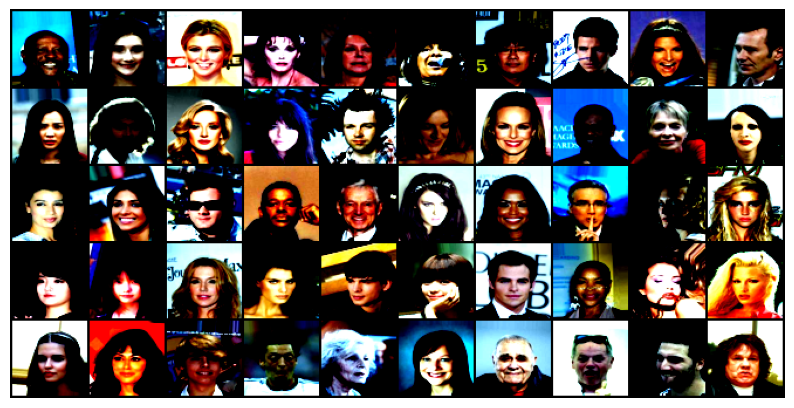


After Denormalization :



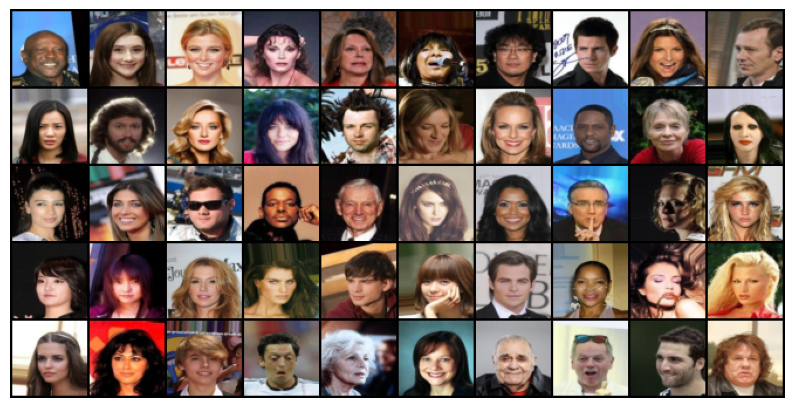

In [9]:
# CelebA Dataset Subset
class CelebASubset(Dataset):
    def __init__(self, root_dir, num_images, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir))[:num_images]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5062, 0.4256, 0.3830], std=[0.3035, 0.2831, 0.2826])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    
# Dataset folder address 
data_root = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebASubset(root_dir=data_root, num_images=num_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Testing the DataLoader
for images, _ in dataloader:
    print(images.size())
    break

# Fetch the first batch from the dataloader
data_iter = iter(dataloader)
images, _ = next(data_iter)  # images shape: [batch_size, 3, img_size, img_size]
    
# Retrieve the first ten images from the batch
first_images = images[0:50]
first_images_d = denormalize(first_images)
    
print('\nAfter Normalization :\n')
# Create Grid
grid = make_grid(first_images, nrow=10)
# Display the image
plt.figure(figsize=(10, 10))
# Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
first_images = grid.permute(1, 2, 0).numpy()
plt.imshow(first_images)
plt.axis('off')  # Hide axis
plt.show()
#save_image(grid, "normalised_dataset_images.png")

print('\nAfter Denormalization :\n')
# Create Grid
grid = make_grid(first_images_d, nrow=10)
# Display the image
plt.figure(figsize=(10, 10))
# Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
first_images = grid.permute(1, 2, 0).numpy()
plt.imshow(first_images)
plt.axis('off')
plt.show()
#save_image(grid, "dataset_images.png")

In [10]:
# Feature-wise affine conditioning (FiLM)
class FeatureWiseAffine(nn.Module):

    def __init__(self, in_channels, out_channels, use_affine_level=True):
        super().__init__()
        self.use_affine_level = use_affine_level
        
        linear_out = out_channels * (2 if use_affine_level else 1)
        self.noise_func = nn.Linear(in_channels, linear_out)

    def forward(self, x, noise_embed):
    
        B, C, H, W = x.shape
        # project embedding
        proj = self.noise_func(noise_embed)        # (B, C*2) or (B, C)

        if self.use_affine_level:
            # split into gamma & beta
            gamma, beta = proj.chunk(2, dim=1)     # each (B, C)
            # reshape to (B, C, 1, 1)
            gamma = gamma.view(B, C, 1, 1)
            beta  = beta.view(B, C, 1, 1)
            return (1 + gamma) * x + beta
        else:
            # simple additive
            bias = proj.view(B, C, 1, 1)
            return x + bias

# get group count
def get_num_groups(channels, max_groups=8):
    g = min(channels, max_groups)
    while channels % g != 0 and g > 1:
        g -= 1
    return max(1, g)

# Residual Block with FiLM conditioning
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.norm1 = nn.GroupNorm(get_num_groups(in_ch), in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = FKConv(in_ch, out_ch, 3, padding=1)
        
        self.norm2 = nn.GroupNorm(get_num_groups(out_ch), out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = FKConv(out_ch, out_ch, 3, padding=1)
        
        self.proj = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else None
        
        self.film = FeatureWiseAffine(time_emb_dim, out_ch) if time_emb_dim else None

    def forward(self, x, t_emb=None):
        out = self.conv1(self.act1(self.norm1(x)))
        out = self.conv2(self.act2(self.norm2(out)))
        if self.film and t_emb is not None:
            out = self.film(out, t_emb)
        skip = self.proj(x) if self.proj else x
        return out + skip

class SelfAttention(nn.Module):
    def __init__(self, groups, channels):
        super().__init__()
        self.norm = nn.GroupNorm(groups, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1)  # (B, C, H*W)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)
        attn = torch.bmm(q.permute(0, 2, 1), k)  # (B, H*W, H*W)
        attn = attn * (C ** -0.5)
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.proj_out(out)
        return out
        
class AttnBlock(nn.Module):
    def __init__(self, groups, channels):
        super().__init__()
        
        self.attn = SelfAttention(groups, channels)
        
    def forward(self, x):
        return x + self.attn(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.res = ResBlock(in_ch, out_ch, time_emb_dim)
        self.down = FKConv(out_ch, out_ch, 4, stride=2, padding=1)
    def forward(self, x, t_emb):
        return self.down(self.res(x, t_emb))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.res = ResBlock(in_ch, out_ch, time_emb_dim)
    def forward(self, x, skip, t_emb):
        x = self.up(x)
        dh = skip.size(2)-x.size(2); dw = skip.size(3)-x.size(3)
        if dh or dw:
            x = F.pad(x, [dw//2, dw-dw//2, dh//2, dh-dh//2])
        return self.res(torch.cat([x, skip],1), t_emb)

class DiffusionUNet(nn.Module):
    def __init__(self, time_emb_dim, in_channels, base_channels, out_channels):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, 4*time_emb_dim),
            nn.SiLU(),
            nn.Linear(4*time_emb_dim, time_emb_dim)
        )
        
        self.init = ResBlock(in_channels, base_channels, time_emb_dim)
        
        # Encoder
        self.down1 = Down(base_channels, base_channels*2, time_emb_dim)
        self.down2 = Down(base_channels*2, base_channels*4, time_emb_dim)
        self.down3 = Down(base_channels*4, base_channels*8, time_emb_dim)
        self.down4 = Down(base_channels*8, base_channels*16, time_emb_dim)
        self.attn3 = AttnBlock(8, base_channels*8)
        self.attn4 = AttnBlock(8, base_channels*16)

        self.bottleneck1 = ResBlock(base_channels*16, base_channels*16, time_emb_dim)
        self.attn_bottleneck = AttnBlock(8, base_channels*16)
        self.bottleneck2 = ResBlock(base_channels*16, base_channels*16, time_emb_dim)

        # Decoder with in_ch = skip + x channels
        self.up4 = Up(base_channels*16 + base_channels*8, base_channels*8, time_emb_dim)
        self.up3 = Up(base_channels*8 +  base_channels*4, base_channels*4, time_emb_dim)
        self.up2 = Up(base_channels*4 +  base_channels*2, base_channels*2, time_emb_dim)
        self.up1 = Up(base_channels*2 +  base_channels,   base_channels,   time_emb_dim)
        self.attn_up4 = AttnBlock(8, base_channels*8)
        self.attn_up3 = AttnBlock(8, base_channels*4)
        
        self.final_res = ResBlock(base_channels, base_channels, time_emb_dim)
        self.final = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x, t):
        
        t_emb = self.time_mlp(t)
        
        x0 = self.init(x, t_emb)
        x1 = self.down1(x0, t_emb)
        x2 = self.down2(x1, t_emb)
        x3 = self.attn3(self.down3(x2, t_emb))
        x4 = self.attn4(self.down4(x3, t_emb))

        xb = self.bottleneck1(x4, t_emb)
        xb = self.attn_bottleneck(xb)
        xb = self.bottleneck1(xb, t_emb)

        x = self.attn_up4(self.up4(xb, x3, t_emb))
        x = self.attn_up3(self.up3(x,  x2, t_emb))
        x = self.up2(x, x1, t_emb)
        x = self.up1(x, x0, t_emb)
        return self.final(self.final_res(x, t_emb))

In [11]:
# Initialize the model
model = DiffusionUNet(in_channels=3, out_channels=3, base_channels=16, time_emb_dim=256)

In [12]:
model

DiffusionUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=1024, bias=True)
    (2): SiLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
  )
  (init): ResBlock(
    (norm1): GroupNorm(3, 3, eps=1e-05, affine=True)
    (act1): SiLU()
    (conv1): FKConv(
      (base_activation): SiLU()
      (base_conv): ModuleList(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (spline_conv): ModuleList(
        (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (layer_norm): ModuleList(
        (0): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (rbf): RadialBasisFunction()
    )
    (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
    (act2): SiLU()
    (conv2): FKConv(
      (base_activation): SiLU()
      (base_conv): ModuleList(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 30561673
Trainable parameters: 30561561


In [14]:
epoch = 25

In [15]:
# Load the saved model state
result = model.load_state_dict(torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",map_location=device, weights_only=False), strict=False)

#result = model.load_state_dict(torch.load(f"/kaggle/input/epoch-60/diffusion_model_kanc_attention_epoch_60.pth", map_location=device, weights_only=False), strict=False)


# Load a smaller model into a larger model
# Load the checkpoint
checkpoint_state = torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",map_location=device, weights_only=False)

#checkpoint_state = torch.load(f"/kaggle/input/epoch-20/diffusion_model_kanc_attention_epoch_20.pth",map_location=device, weights_only=False)

# Get the state dict of the larger model
big_state = model.state_dict()

# Filter out only the parameters that match in key and shape
filtered_state = {}
for key, value in checkpoint_state.items():
    if key in big_state:
        if big_state[key].size() == value.size():
            filtered_state[key] = value
        else:
            print(f"Skipping {key} due to size mismatch: checkpoint {value.size()} vs model {big_state[key].size()}")
    else:
        print(f"Key {key} not found in the big model.")

# Update the big model state with the filtered checkpoint parameters
big_state.update(filtered_state)

# Load the filtered state dict into the big model
result = model.load_state_dict(big_state, strict=False)



# Load a larger model into a smaller model
# Load the checkpoint from the larger model
checkpoint_state = torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",
                              map_location=device, weights_only=False)
#checkpoint_state = torch.load(f"/kaggle/input/epoch-17/diffusion_model_kanc_attention_epoch_17.pth",map_location=device, weights_only=False)

# Get the state dict of the smaller model
small_state = model.state_dict()  # 'model' here is the smaller model

# Filter out only the parameters from the larger model that match in key and shape in the smaller model
filtered_state = {}
for key, value in checkpoint_state.items():
    if key in small_state:
        if small_state[key].size() == value.size():
            filtered_state[key] = value
        else:
            print(f"Skipping {key} due to size mismatch: checkpoint {value.size()} vs model {small_state[key].size()}")
    else:
        print(f"Key {key} not found in the smaller model.")

# Update the smaller model state with the filtered checkpoint parameters
small_state.update(filtered_state)

# Load the filtered state dict into the smaller model
result = model.load_state_dict(small_state)


epoch = 0

# Track losses
all_losses = []
avg_loss_per_epoch = []
last_batch_loss_per_epoch = []

In [16]:
# Load from pickle files
with open(f'/kaggle/working/all_losses_{epoch}.pkl', 'rb') as f:
    all_losses = pickle.load(f)
with open(f'/kaggle/working/avg_loss_per_epoch_{epoch}.pkl', 'rb') as f:
    avg_loss_per_epoch = pickle.load(f)
with open(f'/kaggle/working/last_batch_loss_per_epoch_{epoch}.pkl', 'rb') as f:
    last_batch_loss_per_epoch = pickle.load(f)

In [17]:
print(len(all_losses), len(avg_loss_per_epoch), len(last_batch_loss_per_epoch), epoch)

39575 25 25 25


In [18]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [19]:
model

DataParallel(
  (module): DiffusionUNet(
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): SiLU()
      (3): Linear(in_features=1024, out_features=256, bias=True)
    )
    (init): ResBlock(
      (norm1): GroupNorm(3, 3, eps=1e-05, affine=True)
      (act1): SiLU()
      (conv1): FKConv(
        (base_activation): SiLU()
        (base_conv): ModuleList(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (spline_conv): ModuleList(
          (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (layer_norm): ModuleList(
          (0): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (rbf): RadialBasisFunction()
      )
      (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
      (act2): SiLU()
      (conv2): FKConv(
        (base_activation): SiLU()
        (

In [20]:
model = model.to(device)

In [21]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
# Initialize the diffusion process
diffusion = Diffusion(timesteps=timesteps, device=device)
#diffusion = Diffusion(timesteps=900, device=device)

In [23]:
# Training Loop

# Using mixed-precision training
scaler = torch.amp.GradScaler("cuda")

# Initialize the global timestep counter
#global_t = timesteps-1

# Training mode
model.train()

for i in range(epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [{i+1}/{epochs}]")
    avg = 0.0
    num = 0
    for images, _ in progress_bar:
        
        images = images.to(device, non_blocking=True)
        current_batch_size = images.shape[0]
        
        t = torch.randint(0, timesteps, (current_batch_size,), device=device).long()
        # Generate descending sequence of timesteps using modulo arithmetic
        #t_values = [(global_t - i) % timesteps for i in range(current_batch_size)]
        #t = torch.tensor(t_values, device=device, dtype=torch.long)

        # Update the global timestep counter using modulo arithmetic.
        #global_t = (global_t - current_batch_size) % timesteps
        
        noisy_images, noise = diffusion.add_noise(images, t)
            
        optimizer.zero_grad()
        
        with torch.amp.autocast("cuda"):
            
            predicted_noise = model(noisy_images, t)
            loss = F.mse_loss(predicted_noise, noise)

        #loss.backward()
        scaler.scale(loss).backward()
        
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=5.0) 
        #optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        avg += loss.item()
        num += 1
        all_losses.append(loss.item())
        
        #if loss.item() > 0.03:
            #print((global_t + current_batch_size)%timesteps)
            
        progress_bar.set_postfix({"Current Loss": loss.item(), "Current Avg. Loss": avg/num})
        
    last_batch_loss_per_epoch.append(loss.item())
    avg_loss_per_epoch.append(avg/num)
    
    print(f"Epoch {epoch+1} [{i+1}/{epochs}] Last Batch Loss: {loss.item():.7f}, Avg. Loss = {avg_loss_per_epoch[-1]:.7f}")
    
    # Save model and data
    save_model(model, epoch+1)
    save_data(all_losses, last_batch_loss_per_epoch, avg_loss_per_epoch, epoch+1)
    epoch+=1
    
print("Training Completed")

Epoch 26 [1/10]: 100%|██████████| 1583/1583 [14:45<00:00,  1.79it/s, Current Loss=0.0217, Current Avg. Loss=0.03]  


Epoch 26 [1/10] Last Batch Loss: 0.0216548, Avg. Loss = 0.0300172
Model saved.
Data Saved


Epoch 27 [2/10]: 100%|██████████| 1583/1583 [14:30<00:00,  1.82it/s, Current Loss=0.0237, Current Avg. Loss=0.0299]


Epoch 27 [2/10] Last Batch Loss: 0.0237374, Avg. Loss = 0.0298827
Model saved.
Data Saved


Epoch 28 [3/10]: 100%|██████████| 1583/1583 [14:29<00:00,  1.82it/s, Current Loss=0.0257, Current Avg. Loss=0.0295]


Epoch 28 [3/10] Last Batch Loss: 0.0257345, Avg. Loss = 0.0295487
Model saved.
Data Saved


Epoch 29 [4/10]: 100%|██████████| 1583/1583 [14:33<00:00,  1.81it/s, Current Loss=0.0271, Current Avg. Loss=0.0293]


Epoch 29 [4/10] Last Batch Loss: 0.0270693, Avg. Loss = 0.0292691
Model saved.
Data Saved


Epoch 30 [5/10]: 100%|██████████| 1583/1583 [14:34<00:00,  1.81it/s, Current Loss=0.0324, Current Avg. Loss=0.0293]


Epoch 30 [5/10] Last Batch Loss: 0.0324327, Avg. Loss = 0.0292681
Model saved.
Data Saved


Epoch 31 [6/10]: 100%|██████████| 1583/1583 [14:36<00:00,  1.81it/s, Current Loss=0.0388, Current Avg. Loss=0.0291]


Epoch 31 [6/10] Last Batch Loss: 0.0387623, Avg. Loss = 0.0291253
Model saved.
Data Saved


Epoch 32 [7/10]: 100%|██████████| 1583/1583 [14:42<00:00,  1.79it/s, Current Loss=0.0228, Current Avg. Loss=0.0288]


Epoch 32 [7/10] Last Batch Loss: 0.0227668, Avg. Loss = 0.0287704
Model saved.
Data Saved


Epoch 33 [8/10]: 100%|██████████| 1583/1583 [14:39<00:00,  1.80it/s, Current Loss=0.0326, Current Avg. Loss=0.0289]


Epoch 33 [8/10] Last Batch Loss: 0.0325978, Avg. Loss = 0.0289113
Model saved.
Data Saved


Epoch 34 [9/10]: 100%|██████████| 1583/1583 [14:39<00:00,  1.80it/s, Current Loss=0.0214, Current Avg. Loss=0.029] 


Epoch 34 [9/10] Last Batch Loss: 0.0214344, Avg. Loss = 0.0289652
Model saved.
Data Saved


Epoch 35 [10/10]: 100%|██████████| 1583/1583 [14:39<00:00,  1.80it/s, Current Loss=0.0174, Current Avg. Loss=0.0291]


Epoch 35 [10/10] Last Batch Loss: 0.0173834, Avg. Loss = 0.0290968
Model saved.
Data Saved
Training Completed


In [24]:
#save_model(model, epoch)
#save_data(all_losses, last_batch_loss_per_epoch, avg_loss_per_epoch, epoch)

In [25]:
print(len(all_losses), len(avg_loss_per_epoch), len(last_batch_loss_per_epoch), epoch)

55405 35 35 35


Before denorm: -1.8125427961349487 2.5451290607452393
After denorm: -0.08116751909255981 1.1271755695343018
After clamping: 0.0 1.0


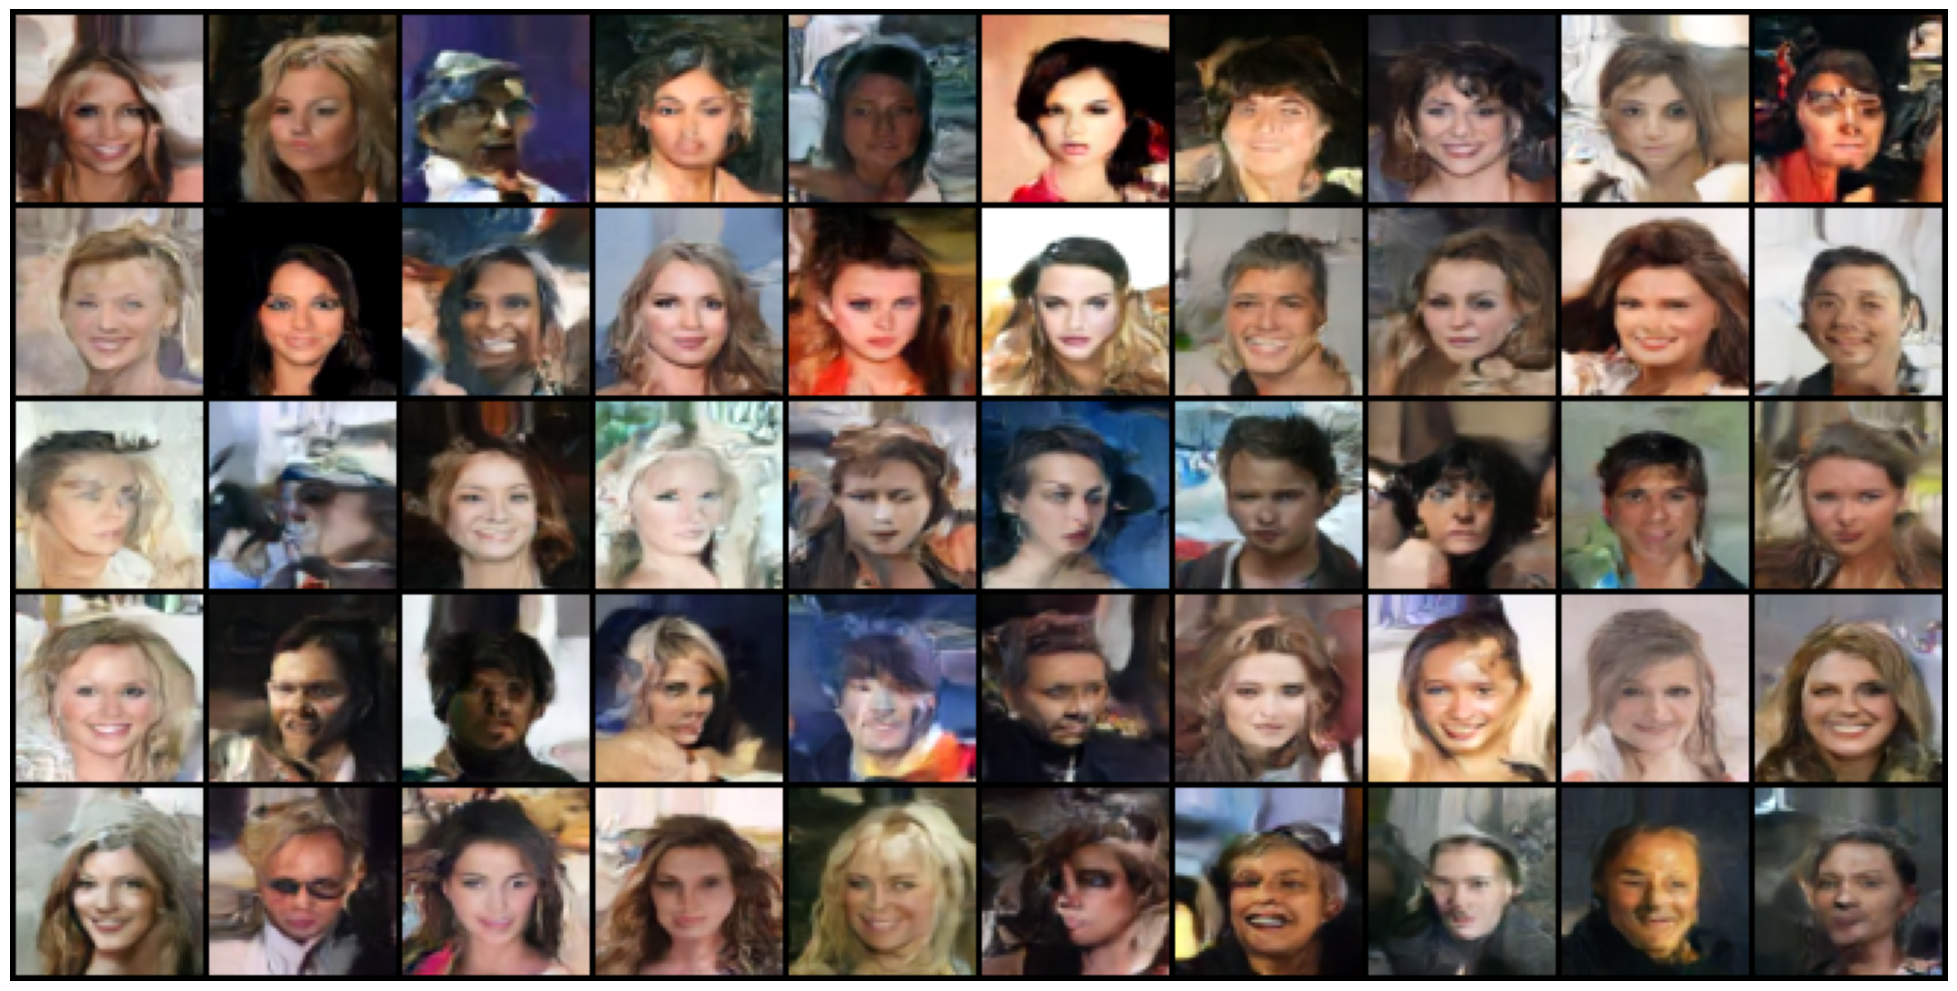

Images Saved


In [26]:
# Generate and display images
display_samples(model, diffusion, device, epoch, n=50, figsize=(25,25),nrow=10, save=1, save_all=0)

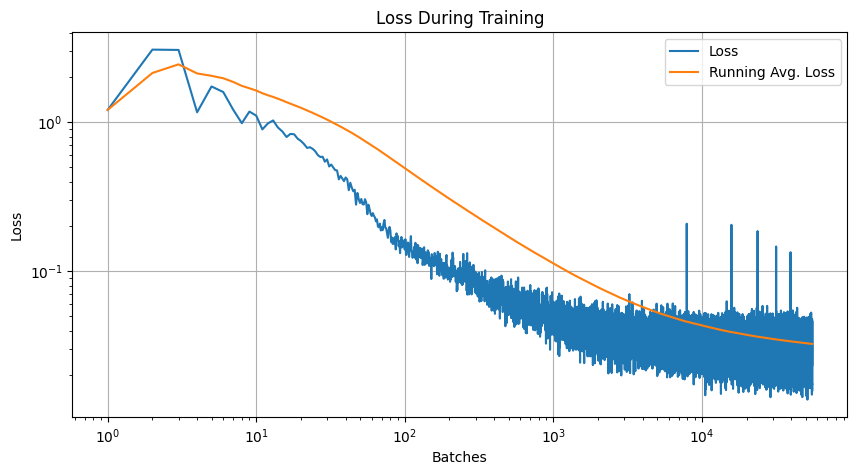

In [27]:
# Calculate running average
cumsum_all_losses = np.cumsum(all_losses)
indices = np.arange(1, len(all_losses) + 1)
running_avg_all_losses = cumsum_all_losses/indices

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(indices, all_losses, label='Loss')
plt.plot(indices, running_avg_all_losses, label='Running Avg. Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.title('Loss During Training')
plt.grid(True)
plt.legend()
plt.show()

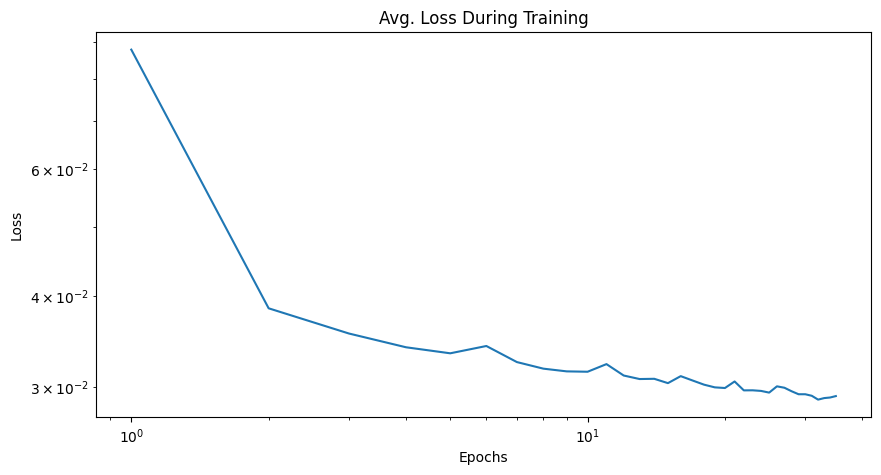

In [28]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,len(avg_loss_per_epoch)+1), avg_loss_per_epoch, label='Avg Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.title('Avg. Loss During Training')
#plt.legend()
plt.show()

In [29]:
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import Subset
from scipy import linalg

num_real = 512
indices = torch.randperm(len(dataset))[:num_real]
real_subset = Subset(dataset, indices)
real_loader = DataLoader(real_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

weights = Inception_V3_Weights.DEFAULT
incept = inception_v3(weights=weights, aux_logits=True, transform_input=False).to(device)
incept.eval()

def get_features(x):
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        x = incept.Conv2d_1a_3x3(x)
        x = incept.Conv2d_2a_3x3(x)
        x = incept.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = incept.Conv2d_3b_1x1(x)
        x = incept.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = incept.Mixed_5b(x)
        x = incept.Mixed_5c(x)
        x = incept.Mixed_5d(x)
        x = incept.Mixed_6a(x)
        x = incept.Mixed_6b(x)
        x = incept.Mixed_6c(x)
        x = incept.Mixed_6d(x)
        x = incept.Mixed_6e(x)
        x = incept.Mixed_7a(x)
        x = incept.Mixed_7b(x)
        x = incept.Mixed_7c(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
    return x.view(x.size(0), -1)

def get_inception_preds(x):
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        out = incept(x)
    # handle whichever format is returned
    if isinstance(out, tuple):
        logits = out[0]
    elif hasattr(out, 'logits'):
        logits = out.logits
    else:
        logits = out
    return F.softmax(logits, dim=1)

@torch.no_grad()
def generate_fake(batch_size):
    z = sample(model, diffusion, (batch_size,3,64,64), device)
    img = denormalize(z.cpu()).clamp(0,1).to(device)
    return img

def compute_fid_and_is(model, diffusion, device, real_loader,
                      num_samples=5120, batch_size=128, splits=10):
    real_feats = []
    for imgs, _ in tqdm(real_loader, desc="Real → feats"):
        mean = torch.tensor([0.5062,0.4256,0.3830]).view(1,3,1,1)
        std  = torch.tensor([0.3035,0.2831,0.2826]).view(1,3,1,1)
        x = torch.clamp(imgs.cpu()*std + mean,0,1).to(device)
        real_feats.append(get_features(x).cpu().numpy())
    real_feats = np.concatenate(real_feats, axis=0)

    fake_feats = []
    preds = []
    n_iters = (num_samples + batch_size - 1)//batch_size
    for _ in tqdm(range(n_iters), desc="Fake → feats & preds"):
        x = generate_fake(batch_size)
        fake_feats.append(get_features(x).cpu().numpy())
        preds.append(get_inception_preds(x).cpu().numpy())
    fake_feats = np.concatenate(fake_feats, axis=0)[:num_samples]
    preds = np.concatenate(preds, axis=0)[:num_samples]

    mu_r, sigma_r = real_feats.mean(0), np.cov(real_feats, rowvar=False)
    mu_g, sigma_g = fake_feats.mean(0), np.cov(fake_feats, rowvar=False)
    diff = mu_r - mu_g
    covmean = linalg.sqrtm(sigma_r.dot(sigma_g))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_val = diff.dot(diff) + np.trace(sigma_r + sigma_g - 2*covmean)

    split_size = num_samples // splits
    scores = []
    for i in range(splits):
        part = preds[i*split_size:(i+1)*split_size]
        py = part.mean(0, keepdims=True)
        kl = part * (np.log(part) - np.log(py))
        scores.append(np.exp(kl.sum(1).mean()))
    is_mean, is_std = float(np.mean(scores)), float(np.std(scores))

    return float(fid_val), is_mean, is_std

model.eval()
fid_score, is_mean, is_std = compute_fid_and_is(
    model, diffusion, device, real_loader,
    num_samples=num_real, batch_size=batch_size, splits=10
)
print(f"FID: {fid_score:.4f}")
print(f"IS : {is_mean:.4f} ± {is_std:.4f}")
print('Epoch :',epoch)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 208MB/s]  
Fake → feats & preds: 100%|██████████| 4/4 [15:29<00:00, 232.35s/it]


FID: 50.6692
IS : 2.2347 ± 0.1215
Epoch : 35


# Extra codes below:

def sample_2(model, diffusion, shape, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape, device=device)
        T = diffusion.timesteps
        img = []
        for t in reversed(range(T)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            epsilon = model(x, t_tensor)
            alpha_t = diffusion.alpha[t]
            alpha_bar_t = diffusion.alpha_bar[t]
            beta_t = diffusion.beta[t]
            alpha_bar_prev = diffusion.alpha_bar[t-1] if t > 0 else torch.tensor(1.0, device=device)
            sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))
            mean = 1 / torch.sqrt(alpha_t) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon)
            noise = torch.randn_like(x) if t > 0 else 0
            x = mean + sigma_t * noise
            if T-t in {1000,900,800,700,600,500,400,300,200,100,1}:
                img.append(x.clone())
        return img

def return_sample(model, diffusion, device, epoch):
    final = []
    while len(final) != 5:
        
        model.eval()
        with torch.no_grad():
            samples = sample_2(model, diffusion, (1, 3, 64, 64), device)
            
            samples = torch.cat(samples, dim=0)
            print(samples.shape)
            samples_2 = samples.clone()
            print(samples_2.shape)
            
        print("Before denorm:", samples_2.min().item(), samples_2.max().item())
        denorm_images_2 = denormalize(samples_2.cpu())
        print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
        final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
        print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
        
        grid2 = make_grid(final_images_2, nrow=11)
        
        plt.figure(figsize=(20,5))
        plt.imshow(grid2.permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.show()
        if input('add??')=='yes':
            final.append(samples)
    return final

x = return_sample(model, diffusion, device, epoch)

x1 = torch.clamp(denormalize(torch.cat(x).view(5,11,3,64,64).cpu()),0.0,1.0).view(-1,3,64,64)
print(x1.shape)
grid2 = make_grid(x1, nrow=11)

save_image(grid2, "Final Variant 2.png")
plt.figure(figsize=(20,20))
plt.imshow(grid2.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(2, 61))

# Average loss per epoch for each variant
loss = {
    'Standard U-Net': [
        0.0326838, 0.0313284, 0.0301285, 0.0295897, 0.0293598, 0.0294049, 0.0291919, 0.0290907, 0.0288836,
        0.0309629, 0.0289148, 0.0283897, 0.0280236, 0.0279870, 0.0278983, 0.0276963, 0.0272809, 0.0275412, 0.0276143,
        0.0284495, 0.0280132, 0.0276644, 0.0276460, 0.0270795, 0.0277710, 0.0275043, 0.0273313, 0.0271018, 0.0266853,
        0.0274620, 0.0273208, 0.0269829, 0.0267904, 0.0268817, 0.0277106, 0.0271781, 0.0267692, 0.0269842, 0.0267217,
        0.0266270, 0.0265374, 0.0264814, 0.0265379, 0.0264603, 0.0272182, 0.0271341, 0.0266555, 0.0266141, 0.0266708,
        0.0268776, 0.0264605, 0.0267695, 0.0267070, 0.0262338, 0.0268719, 0.0264014, 0.0263073, 0.0262484, 0.0262917
    ],
    'FastKAN U-Net': [
        0.0373245, 0.0341708, 0.0330053, 0.0321781, 0.0316577, 0.0312065, 0.0309617, 0.0308374, 0.0306304,
        0.0315004, 0.0309264, 0.0301526, 0.0302531, 0.0302541, 0.0299004, 0.0300635, 0.0297322, 0.0296018, 0.0298534,
        0.0305988, 0.0298832, 0.0297721, 0.0293115, 0.0294261, 0.0302375, 0.0294484, 0.0293598, 0.0293673, 0.0290660,
        0.0299975, 0.0292843, 0.0292137, 0.0288092, 0.0288803, 0.0294766, 0.0291941, 0.0288024, 0.0289583, 0.0289135,
        0.0296783, 0.0290424, 0.0288578, 0.0285636, 0.0285353, 0.0289993, 0.0286804, 0.0285152, 0.0284577, 0.0283108,
        0.0291083, 0.0287053, 0.0284215, 0.0283405, 0.0282949, 0.0286066, 0.0283507, 0.0282984, 0.0279882, 0.0279559
    ],
    'FastKAN Bottleneck U-Net': [
        0.0354878, 0.0324082, 0.0309436, 0.0300794, 0.0294864, 0.0291873, 0.0290919, 0.0286669, 0.0281615,
        0.0289658, 0.0283198, 0.0281319, 0.0279321, 0.0275317, 0.0277703, 0.0278196, 0.0276342, 0.0276556, 0.0277444,
        0.0283149, 0.0279549, 0.0276822, 0.0277315, 0.0275462, 0.0281670, 0.0276664, 0.0277407, 0.0270537, 0.0275692,
        0.0280356, 0.0275860, 0.0273087, 0.0272032, 0.0270305, 0.0279174, 0.0273715, 0.0270926, 0.0270317, 0.0270561,
        0.0269814, 0.0268123, 0.0267671, 0.0267443, 0.0267357, 0.0276684, 0.0273199, 0.0270109, 0.0268249, 0.0264568,
        0.0274018, 0.0272374, 0.0270839, 0.0267488, 0.0269014, 0.0269128, 0.0268027, 0.0267685, 0.0264634, 0.0267898
    ]
}

# FID scores at selected epochs
fid = {
    'Standard U-Net': {
                       10:66.1739,
                       20:52.9952,
                       30:47.1528,
                       40:51.1647,
                       50:44.9067,
                       55:39.3865,
                       60:36.2896
                      },
    'FastKAN U-Net': {
                       10:54.9416,
                       20:62.7888,
                       30:49.1107,
                       40:67.2348,
                       50:56.7396,
                       55:52.6343,
                       60:44.3570
                      },
    'FastKAN Bottleneck U-Net': {
                       10:47.5997,
                       20:44.7399,
                       30:42.1634,
                       40:42.9428,
                       50:40.1829, 
                       55:39.1097, 
                       60:37.0646
                      }
}

# 1) Plot training loss curves
plt.figure(figsize=(10, 5))
for name, values in loss.items():
    plt.plot(epochs, values, label=name)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2) Plot FID at selected epochs
plt.figure(figsize=(10, 5))
for name, scores in fid.items():
    x = list(scores.keys())
    y = [scores[e] for e in x]
    plt.plot(x, y, marker='o', label=name)
plt.xlabel('Epoch')
plt.ylabel('Frechet Inception Distance (FID)')
plt.title('FID at Selected Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Function to generate and display images
def display_samples_check(model, d_n, device, n=16, figsize=(15,15), nrow=4, save=1):
    
    diffusion = Diffusion(timesteps=d_n, device=device)
    
    model.eval()
    with torch.no_grad():
        samples = sample(model, diffusion, (n, 3, 64, 64), device, save_all=0)
        samples_2 = samples.clone()
        
    
    print("*********** Scaled Version ***********")
    print("Before scaling:", samples.min().item(), samples.max().item())
    output_scaler = OutputScaler().to(device)
    scaled = output_scaler(samples)
    print("Before denorm:", scaled.min().item(), scaled.max().item())
    denorm_images = denormalize(scaled.cpu())
    print("After denorm:", denorm_images.min().item(), denorm_images.max().item())
    final_images = torch.clamp(denorm_images, 0.0, 1.0)
    print("After clamping:", final_images.min().item(), final_images.max().item())
    
    grid = make_grid(final_images, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    print("\n\n\n*********** Not Scaled Version ***********")
    print("Before denorm:", samples_2.min().item(), samples_2.max().item())
    denorm_images_2 = denormalize(samples_2.cpu())
    print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
    final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
    print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
    
    grid2 = make_grid(final_images_2, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid2.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    if save:
        save_image(grid, f"check/generated_images_scaled_{d_n}.png")
        save_image(grid2, f"check/generated_images_not_scaled_{d_n}.png")
        print(f"Images Saved {d_n}")

for i in range(100,1001,100):
    display_samples_check(model, i, device, n=16, figsize=(16,16),nrow=4, save=1)

torch.nn.utils.clip_grad_norm_(
    parameters,      # Iterable of parameters or a single parameter tensor whose gradients will be clipped.
    max_norm,        # The maximum norm (float) of the gradients allowed.
    norm_type=2.0,   # Type of norm to use (default is 2, i.e., the L2 norm). You can also use other values like 1.0 for L1 norm.
    error_if_nonfinite=False  # If set to True, will raise an error if the total norm is NaN or infinite.
)

pretrained_params = []
new_params = []
for name, param in model.named_parameters():
    if name in load_result.missing_keys:
        new_params.append(param)
    else:
        pretrained_params.append(param)

# Now create an optimizer with different learning rates
optimizer = torch.optim.AdamW([
    {'params': pretrained_params, 'lr': 1e-4},  # lower LR for pretrained weights
    {'params': new_params, 'lr': 1e-3}          # higher LR for new layers
])

import torch
from torchvision import transforms

from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

class CelebASubset(Dataset):
    def __init__(self, root_dir, num_images, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir))[:num_images]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0
        
# Function to compute dataset mean and std
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    total_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten spatial dimensions
        mean += images.mean([0, 2]) * batch_samples
        std += images.std([0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

# Define a dataset without normalization
transform_no_norm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
num_images = 200000
data_root = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebASubset(root_dir=data_root, num_images=num_images, transform=transform_no_norm)

# Compute mean and std
mean, std = compute_mean_std(dataset)
print("Mean:", mean)
print("Std:", std)
